1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard
deviation
* Fill a histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of the Y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter
that can be tuned. The std default value should be:
``` 1.06 * x.std() * x.size  ** -0.2 ```
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the
integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method

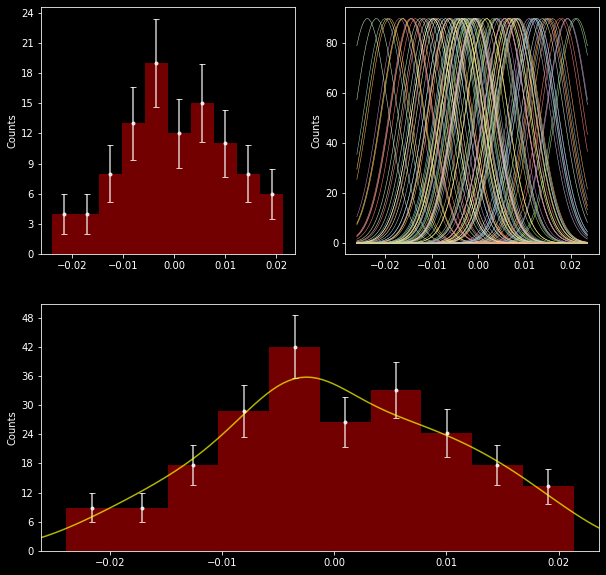

In [2]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use("dark_background")

grid = (2,2)
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid(grid, (0, 0))
ax2 = plt.subplot2grid(grid, (0, 1))
ax3 = plt.subplot2grid(grid, (1, 0), colspan=2)

# Gaussian histogram
mu, sigma, size = 0.0, 0.01, 100
normarr = np.random.normal(mu, sigma, size)
nbins = m.isqrt(size)
counts = ax1.hist(normarr, nbins, color="red", alpha=0.45)
ax1.set_ylabel("Counts")
xl, xr = ax1.get_xlim()
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
midpoints = (counts[1][1:] + counts[1][:-1])/2
ax1.errorbar(midpoints, counts[0], yerr=np.sqrt(counts[0]), fmt=".", color="white", capsize=3.0, alpha=0.8)

# Sub-gaussians plot
import scipy.integrate as sint
import scipy.stats as st

std = 1.06 * normarr.std() * normarr.size  ** -0.2

sub_gaussians = []
xaxis = np.linspace(xl, xr, num=100)
for element in normarr:
    one_gau = st.norm(loc=element, scale=std).pdf(xaxis)
    sub_gaussians.append(one_gau)
    ax2.plot(xaxis, one_gau, linewidth=0.5)
ax2.set_ylabel("Counts")

# Summed up sub-gaussians and histogram
total_gaussian = np.sum(sub_gaussians, axis=0)
total_gaussian = total_gaussian / sint.trapezoid(total_gaussian, xaxis)
counts = ax3.hist(normarr, nbins, density=True, color="red", alpha=0.45)
midpoints = (counts[1][1:] + counts[1][:-1])/2
ax3.errorbar(midpoints, counts[0], yerr=np.sqrt(counts[0]), fmt=".", color="white", capsize=3.0, alpha=0.8)
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.plot(xaxis, total_gaussian, color="yellow", alpha=0.7)
ax3.set_ylabel("Counts")
ax3.set_xlim(xl, xr)
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with
a given mean and std (clearly it is better to have different valued means...)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

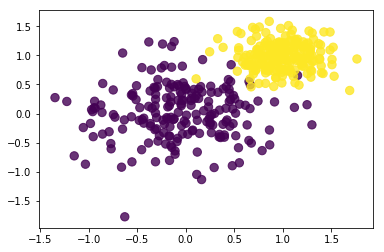

In [3]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('./data/two_categories_scatter_plot.png')

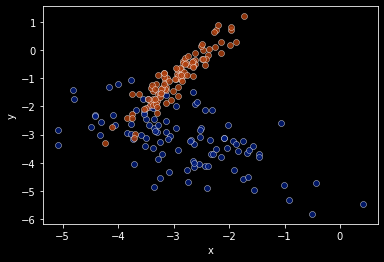

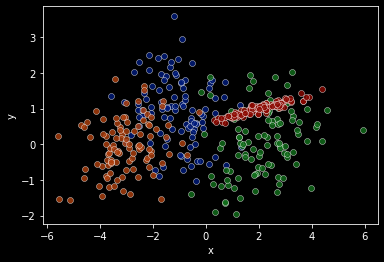

In [4]:
import pandas as pd
import seaborn as sns

def n_category_2d_gaussian_scatter(sample_size, n=2):
    sns.set_palette("dark", n)
    for it in range(n):
        mean = np.random.randint(-3, 3, size=2)
        cov = np.random.uniform(-1.0, 1.0, (2, 2))
        cov = np.dot(cov, cov.transpose())
        gaussian_2d = np.random.multivariate_normal(mean, cov, sample_size)
        gdf = pd.DataFrame(gaussian_2d, columns=["x", "y"])
        sns.scatterplot(x='x', y='y', data=gdf, alpha=0.8)
    plt.show()

n_category_2d_gaussian_scatter(100)
n_category_2d_gaussian_scatter(100, n=4)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method,
and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression.
The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable
  number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

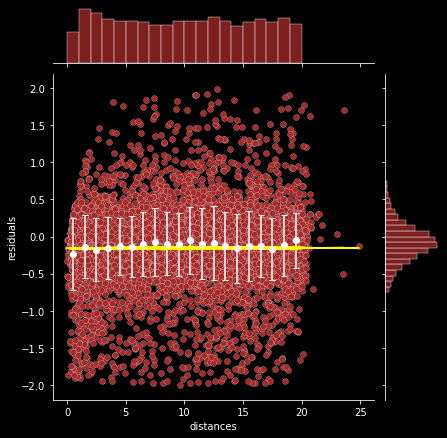

In [55]:
data = np.load("data/residuals_261.npy", allow_pickle=True)

df = pd.DataFrame(data.item())
df = df[np.fabs(df["residuals"]) < 2.0]
length = (len(df["distances"]), len(df["residuals"]))
j_plot = sns.JointGrid()
#Scatter
sns.scatterplot(x=df["distances"], y=df["residuals"], color="brown", ax=j_plot.ax_joint, linewidth=0.2)
#Histograms
sns.histplot(x=df["distances"], ax=j_plot.ax_marg_x, color="brown", bins=20, binrange=(0, 20), linewidth=0.4)
sns.histplot(y=df["residuals"], ax=j_plot.ax_marg_y, color="brown", bins=20, binrange=(-.75, .75), linewidth=0.4)
#Linear regression
slope, intercept, r_value, p_value, std_err = st.linregress(df["distances"], df["residuals"])
j_plot.ax_joint.plot(df["distances"], intercept + slope * df["residuals"], color="yellow")
#Averages
x = np.arange(0, 21, 1)
y = df.groupby(pd.cut(df["distances"], bins = x)).mean()["residuals"]
yerr = df.groupby(pd.cut(df["distances"], bins = x)).std()["residuals"]
midpoints = (x[1:] + x[:-1]) / 2
j_plot.ax_joint.errorbar(midpoints, y, yerr=yerr, fmt="o", color="white", capsize=3.0)

plt.xlabel("distances")
plt.ylabel("residuals")
plt.show()